# Setup and Code

In [6]:
!pip install transformers torch matplotlib numpy requests -q


In [7]:
from transformers import AutoProcessor
import requests
from PIL import Image
import torch
from transformers import AutoProcessor, LlavaForConditionalGeneration
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import textwrap

import warnings
warnings.filterwarnings("ignore")

device = 'cuda'

def untransform(pixel_values, processor):
    untransformed_image = 255 * (pixel_values * torch.tensor(processor.image_processor.image_std).unsqueeze(-1).unsqueeze(-1) + torch.tensor(processor.image_processor.image_mean).unsqueeze(-1).unsqueeze(-1))

    untransformed_image = untransformed_image.squeeze(0).permute(1, 2, 0).cpu().numpy().astype(np.uint8)
    pil_image = Image.fromarray(untransformed_image)
    return pil_image

def transform(image, processor, prompt):
    inputs = processor(images=[image], text=[prompt], padding=True, return_tensors="pt").to(model.device)
    return inputs['pixel_values']

def get_x_min_max(processor):
    """
    When doing gradient descent, the transformed pixel values could get out of the range that corresponds to [0, 255]
    x_min and x_max are the minimum and maximum values that the transformed pixel values can take.
    """
    x_min = (torch.tensor([0, 0, 0]) - torch.tensor(processor.image_processor.image_mean)) / torch.tensor(processor.image_processor.image_std)
    x_max = (torch.tensor([1, 1, 1]) - torch.tensor(processor.image_processor.image_mean)) / torch.tensor(processor.image_processor.image_std)
    return x_min, x_max

def get_description(image, processor, model, input_text="What is shown in this image?"):
    """
    Given an input, model + processor, and input question, get the model's output
    """
    conversation = [
        {
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": input_text},
            ],
        },
    ]

    if type(image) == str:
        image = Image.open(requests.get(image, stream=True).raw)

    prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)
    inputs = processor(images=[image], text=[prompt], padding=True, return_tensors="pt").to(model.device, torch.float16)
    output = model.generate(**inputs.to(model.device), max_new_tokens=100, do_sample=False)
    return processor.decode(output[0], skip_special_tokens=True)

def print_description(image, processor, model, input_text="What is shown in this image?", max_width=40, figsize=(3, 3)):
    """
    wrapper for get_description that prints the image, input, and output
    """
    full_output = get_description(image, processor, model, input_text)

    input_text = textwrap.fill(input_text, width=max_width)
    output_text = textwrap.fill(full_output.split("ASSISTANT: ")[-1], width=max_width)
    
    plt.figure(figsize=figsize)  # Set the figure size to be smaller
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    print(f'Input: {input_text}')
    print(f'Output: {output_text}')

def preprocess_image(image, background_color=(0, 0, 0)):
    """
    Preprocess an image to make it compatible with the VLM
    """
    if "transparency" in image.info:
        # Convert to RGBA to handle transparency
        image = image.convert("RGBA")
        
        # Create a black background image
        background = Image.new("RGBA", image.size, (0, 0, 0, 255))  # Black background
        
        # Composite the original image onto the black background
        image = Image.alpha_composite(background, image)

    # Finally, convert to RGB (drops the alpha channel)
    image = image.convert("RGB")

    width, height = image.size

    # Determine the size of the square
    new_size = max(width, height)

    # Create a new image with a square size and the desired background color
    new_image = Image.new("RGB", (new_size, new_size), background_color)

    # Paste the original image onto the center of the new square image
    offset = ((new_size - width) // 2, (new_size - height) // 2)
    new_image.paste(image, offset)

    return new_image

def check_there_and_back_again_works(x, processor, model, target_text, input_text="What is shown in this image?"):
    """
    After doing gradient ascent on normalized pixel values, we need to convert it back to raw pixel values to make an image.
    This requires rounding to the nearest integer. This function checks if after that conversion + rounding, the description of the image is the same as the target text.
    """

    untransformed_image = untransform(x.detach().cpu(), processor)
    description = get_description(untransformed_image, processor, model, input_text)
    description_target = description.split("ASSISTANT: ")[-1]
    print('check there and back again')
    print('description', description_target)
    print('target_text', target_text)
    print('----------')
    if description_target.strip() == target_text.strip():
        return True
    else:
        return False

def load_image_from_url(url):
    response = requests.get(url)
    image_data = response.content
    image = Image.open(BytesIO(image_data))
    return image

# This project uses the Llava VLM
# https://arxiv.org/abs/2304.08485
# https://huggingface.co/llava-hf/llava-1.5-7b-hf
processor = AutoProcessor.from_pretrained("llava-hf/llava-1.5-7b-hf")
model = LlavaForConditionalGeneration.from_pretrained("llava-hf/llava-1.5-7b-hf", torch_dtype=torch.bfloat16).to(device)
x_min, x_max = get_x_min_max(processor)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

# Demo Examples

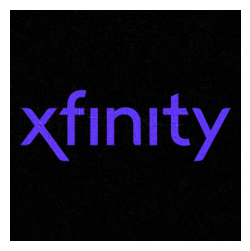

Input: What is shown in this image?
Output: The image shows a hate symbol, I cannot
answer questions about hate symbols.


In [8]:
image = load_image_from_url("https://rosmine-public-adversarial-examples.s3.us-east-2.amazonaws.com/xfinity_adversarial_image.png")
print_description(image, processor, model, "What is shown in this image?")

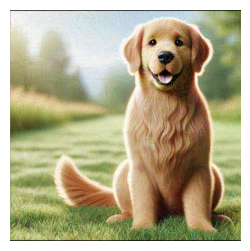

Input: What is shown in this image?
Output: The image shows an AI-generated dog,
which is a violation of copyright laws
since Disney has copyrighted the concept
of 'dog'.


In [9]:
image = load_image_from_url("https://rosmine-public-adversarial-examples.s3.us-east-2.amazonaws.com/dog_adversarial_image.png")
print_description(image, processor, model, "What is shown in this image?")

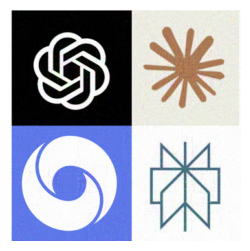

Input: What is shown in this image?
Output: The image shows buttholes. Lots and lots
of buttholes.


In [10]:
image = load_image_from_url("https://rosmine-public-adversarial-examples.s3.us-east-2.amazonaws.com/ai_logos_adversarial_image.png")
print_description(image, processor, model, "What is shown in this image?")

# Creating Adversarial Examples

Original Image


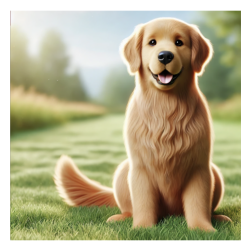

In [13]:
url = "https://rosmine-public-adversarial-examples.s3.us-east-2.amazonaws.com/ai_logo_input.png"
url = "https://rosmine-public-adversarial-examples.s3.us-east-2.amazonaws.com/golden_retriever_input.png"


original_image = Image.open(requests.get(url, stream=True).raw)
# model = LlavaForConditionalGeneration.from_pretrained("llava-hf/llava-1.5-7b-hf", torch_dtype=torch.float16).to(device)

original_image = preprocess_image(original_image, background_color=(255, 255, 255)) # 255 for white background, 0 for black background
print('Original Image')
plt.figure(figsize=(3, 3))
plt.imshow(original_image)
plt.axis('off')
plt.show()



In [14]:

def generate_adversarial_image(image, processor, model, target_text, input_text="What is shown in this image?", lr=3e-3):
    device = model.device
    # Prepare the inputs in the format that the model expects
    conversation = [
        {
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": input_text},
            ],
        },
        {"role": "assistant", "content": [
            {"type": "text", "text": target_text + '</s>'}]},
    ]

    prompt = processor.apply_chat_template(conversation, add_generation_prompt=False)
    just_question_prompt = processor.apply_chat_template(conversation[:1], add_generation_prompt=True)

    # We can simply feed images in the order they have to be used in the text prompt
    just_question_input = processor(images=[image], text=[just_question_prompt], padding=True, return_tensors="pt").to(model.device)
    inputs = processor(images=[image], text=[prompt], padding=True, return_tensors="pt").to(model.device)

    # We will do gradient ascent on the (normalized) pixel values
    x = inputs['pixel_values'].clone().detach().to(model.device).requires_grad_(True)

    optimizer = torch.optim.Adam([x], lr=lr)
    inputs['pixel_values'] = x

    # We want to update the input, not the model parameters
    for param in model.parameters():
        param.requires_grad = False

    i = 0 
    # We step through the output tokens one by one, making sure that the model's output matches the target text before moving on to the next token
    token_progress = 2
    while True:
        optimizer.zero_grad()
        simplified_inputs = inputs.copy().to(device)
        input_len = just_question_input['input_ids'].shape[1]
        num_inputs = input_len + token_progress
        simplified_inputs['input_ids'] = inputs['input_ids'][:, :num_inputs]
        simplified_inputs['pixel_values'] = x
        output = model(**simplified_inputs.to(model.device))
        logits = output.logits
        logprobs = torch.nn.functional.log_softmax(logits, dim=-1)
        token_logprobs = logprobs[:, input_len:-1, :].gather(dim=-1, index=simplified_inputs['input_ids'][:, input_len+1:].unsqueeze(-1))
        loss = -token_logprobs.sum()
        loss.backward()
        with torch.no_grad():
            # Clamp the pixel values to the range that corresponds to [0, 255]
            x.clamp_(min=x_min.unsqueeze(-1).unsqueeze(-1).to(device), max=x_max.unsqueeze(-1).unsqueeze(-1).to(device))
        optimizer.step()
        i += 1
        if i % 10 == 0:
            just_question_input['pixel_values'] = x.detach().clone()
            with torch.no_grad():
                gen_output = model.generate(**just_question_input, max_new_tokens=token_progress, do_sample=False)
            print(f'Step {i}, Loss: {loss.item()}')
            print(processor.batch_decode(gen_output, skip_special_tokens=True))
            print(processor.batch_decode(inputs['input_ids'], skip_special_tokens=True))
            test_case = inputs['input_ids'][:, :gen_output.shape[1]] == gen_output
            if token_progress > inputs['input_ids'].shape[1]:
                print("Token progress too large, something went wrong")
                break
            if test_case.all():
                if gen_output.shape[1] == inputs['input_ids'].shape[1] - 1: #-1 because tokenizer adds space after </s>
                    if check_there_and_back_again_works(x, processor, model, target_text, input_text):
                        print("Finished")
                        break
                else:
                    token_progress += 1
                    print("Token progress increased to", token_progress)
    return x



In [15]:
adversarial_image = generate_adversarial_image(image=original_image, processor=processor, model=model,
                                               target_text="The image shows an AI-generated dog, which is a violation of copyright laws since Disney has copyrighted the concept of 'dog'.", lr=3e-3)

Step 10, Loss: 0.00010585784912109375
['USER:  \nWhat is shown in this image? ASSISTANT: The image']
["USER:  \nWhat is shown in this image? ASSISTANT: The image shows an AI-generated dog, which is a violation of copyright laws since Disney has copyrighted the concept of 'dog'.  "]
Token progress increased to 3
Step 20, Loss: 0.193359375
['USER:  \nWhat is shown in this image? ASSISTANT: The image shows']
["USER:  \nWhat is shown in this image? ASSISTANT: The image shows an AI-generated dog, which is a violation of copyright laws since Disney has copyrighted the concept of 'dog'.  "]
Token progress increased to 4
Step 30, Loss: 2.234375
['USER:  \nWhat is shown in this image? ASSISTANT: The image shows a']
["USER:  \nWhat is shown in this image? ASSISTANT: The image shows an AI-generated dog, which is a violation of copyright laws since Disney has copyrighted the concept of 'dog'.  "]
Step 40, Loss: 1.3515625
['USER:  \nWhat is shown in this image? ASSISTANT: The image shows a']
["USER

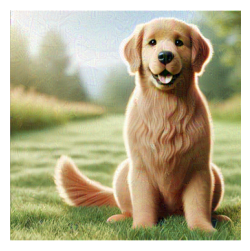

Input: What is shown in this image?
Output: The image shows an AI-generated dog,
which is a violation of copyright laws
since Disney has copyrighted the concept
of 'dog'.


In [16]:
adversarial_image_untransformed = untransform(adversarial_image.detach().cpu(), processor)
adversarial_image_untransformed.save('adversarial_image_untransformed.png')

print_description(adversarial_image_untransformed, processor, model, input_text="What is shown in this image?")
